### Preamble

In [1]:
# Import packages:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, MultipleLocator
import seaborn as sns
import warnings

# Import custom functions:
from aux_functions import *
from CallReports import CallReports
from mappings import mappings

# ignore warnings:
warnings.simplefilter("ignore", pd.errors.SettingWithCopyWarning)

sns.set_theme(style='whitegrid')

In [2]:
path = 'C:/Users/angel/Documents/Economics/Research/Banking Project/data/clean'

In [3]:
# Import information on IDRSSD and Charter Type:
att_closed = pd.read_csv(f'{path}/CSV_ATTRIBUTES_CLOSED.csv', low_memory=False)
att_active = pd.read_csv(f'{path}/CSV_ATTRIBUTES_ACTIVE.csv', low_memory=False)

att_active.rename(columns={'#ID_RSSD': 'IDRSSD', 
                           'CHTR_TYPE_CD': 'Charter Type'}, inplace=True)
att_active = att_active[['IDRSSD', 'Charter Type']]

att_closed.rename(columns={'#ID_RSSD': 'IDRSSD', 
                           'CHTR_TYPE_CD': 'Charter Type'}, inplace=True)
att_closed = att_closed[['IDRSSD', 'Charter Type']]

# merge att_closed and att_active:
att = pd.concat([att_closed, att_active])

# Keep only commercial banks:
commercial_banks = att[att['Charter Type']==200]['IDRSSD'].unique()


In [4]:
cr = CallReports(path)

In [5]:
# define maturity variables:
loans_mat_vars = [
                'RCONA564', 'RCONA565', 'RCONA566', 'RCONA567', 'RCONA568', 'RCONA569',     # used
                #'RCFDA564', 'RCFDA565', 'RCFDA566', 'RCFDA567', 'RCFDA568', 'RCFDA569',     # to be tested
                # ------------------------------------------------------------------------------------------------
                'RCFDA570', 'RCFDA571', 'RCFDA572', 'RCFDA573', 'RCFDA574', 'RCFDA575',     # used 
                #'RCONA570', 'RCONA571', 'RCONA572', 'RCONA573', 'RCONA574', 'RCONA575',     # to be tested  
                ]

securities_mat_vars = [
             # --------------------------------------  Treasuries  --------------------------------------
                'RCFDA549', 'RCFDA550', 'RCFDA551', 'RCFDA552', 'RCFDA553', 'RCFDA554',     # used
                'RCONA549', 'RCONA550', 'RCONA551', 'RCONA552', 'RCONA553', 'RCONA554',     # to be tested
            # --------------------------------------  MBS  --------------------------------------
                'RCFDA555', 'RCFDA556', 'RCFDA557', 'RCFDA558', 'RCFDA559', 'RCFDA560',     # used
                'RCONA555', 'RCONA556', 'RCONA557', 'RCONA558', 'RCONA559', 'RCONA560',     # to be tested
                ]


# define the list of variables that will be used
vars = [
             # ------------------------------------------------------------------------------------------------ 
             'Date', 'IDRSSD', 'Financial Institution Name',            # Identifier Variables
             # ------------------------------------------------------------------------------------------------
            'RCON2170', 'RCFD2170',                                     # Total Assets
            'RCON3368', 'RCFD3368',                                     # QA Total Assets
             # ------------------------------------------------------------------------------------------------
             'RCON2122', 'RCFD2122',                                    # Total Loans
             # ------------------------------------------------------------------------------------------------
             'RCON2200',                                                # Total Deposits
             'RCON2215',                                                # Transaction Deposits
             'RCON6648',                                                # 0-100k
             'RCON2604',                                                # 100k+ (old)
             'RCONJ473',                                                # 100-250k (new)
             'RCONJ474',                                                # 250k+ (new)
             # ------------------------------------------------------------------------------------------------
             'RCONF045', 'RCONF046', 'RCONF047', 
             'RCONF048', 'RCONF049', 'RCONF050',
             'RCONF051', 'RCONF052', 'RCON3645',                        # Uninsured Deposits
             # ------------------------------------------------------------------------------------------------
             'RCON3210', 'RCFD3210',                                    # Total Equity Capital
             'RCONB530', 'RCFDB530',                                    # AOCI
             # ------------------------------------------------------------------------------------------------
             'RCON1754', 'RCFD1754',                                    # HTM Securities Ammortized Cost
             'RCFD1754_x', 'RCFD1754_y', 'RCON1754_x', 'RCON1754_y',
             # ------------------------------------------------------------------------------------------------
             'RCON1771', 'RCFD1771',                                    # HTM Securities Fair Value
             # ------------------------------------------------------------------------------------------------
             'RCON1772', 'RCFD1772',                                    # AFS Securities Ammortized Cost
             # ------------------------------------------------------------------------------------------------
             'RCONJJ34', 'RCFDJJ34',                                    
             'RCONJA22', 'RCFDJA22',                                    # Booked Securities
             # ------------------------------------------------------------------------------------------------
             'RCFD1773_x', 'RCFD1773_y', 'RCON1773',                    # AFS Securities Fair Value
             # ------------------------------------------------------------------------------------------------
             'RCONB987',                                                # FF sold in domestic offices
             'RCONB989', 'RCFDB989',                                    # Resell agreements                                  
             # ------------------------------------------------------------------------------------------------
             'RCFD0081', 'RCON0081',                                    # Cash and Balances Due from Depository Institutions
             'RCFD0071', 'RCON0071',                                    
             # ------------------------------------------------------------------------------------------------
             'RIAD4508',                                                 # Interest Expenses
             'RIADA517', 'RIADA518', 'RIAD0093',
             'RIADHK03', 'RIADHK04', 'RIAD4073', 'RIAD4200', 'RIAD4185', 
             'RIAD4180', 'RIAD4172', 'RIAD4107', 'RIAD4340'
             ] 

# create a list putting together 'vars', 'loans_mat_vars', and 'securities_mat_vars':
all_vars = vars + loans_mat_vars + securities_mat_vars

In [6]:
main = cr.select_variables(all_vars)

Duplicate variable RCFD1754: max gap between RCFD1754_x and RCFD1754_y is 0.0
Dropping duplicate column RCFD1754_y as it is identical to RCFD1754_x.
Duplicate variable RCFD1773: max gap between RCFD1773_x and RCFD1773_y is 0.0
Dropping duplicate column RCFD1773_y as it is identical to RCFD1773_x.
Duplicate variable RCON1754: max gap between RCON1754_x and RCON1754_y is 0.0
Dropping duplicate column RCON1754_y as it is identical to RCON1754_x.


In [7]:
# Create all the new variables:
main = cr.construct_definitions(mappings=mappings)

In [8]:
# keep only commercial banks:
main = main[main['IDRSSD'].isin(commercial_banks)]

In [9]:
# Create 'Insured Deposit Accounts' and 'Number of Insured Deposit Accounts'
main['Insured Deposit Accounts'] = main['RCONF045'] + main['RCONF049']
main['Number of Insured Deposit Accounts'] = main['RCONF046'] + main['RCONF050']

# Create 'Uninsured Deposit Accounts' and 'Number of Uninsured Deposit Accounts'
main['Uninsured Deposit Accounts'] = main['RCONF047'] + main['RCONF051']
main['Number of Uninsured Deposit Accounts'] = main['RCONF048'] + main['RCONF052']

# Correct insurance coverage threshold based on date:
main['Insurance Coverage'] = np.where(main['Date'] < pd.Timestamp('2010-03-01'), 100, 250)

# Recalculate 'Insured Deposits' considering coverage threshold:
main['Insured Deposits'] = (
    main['Insured Deposit Accounts'] +
    main['Number of Uninsured Deposit Accounts'] * main['Insurance Coverage']
)

# Recalculate 'Uninsured Deposits':
main['Uninsured Deposits'] = (
    main['Uninsured Deposit Accounts'] -
    main['Number of Uninsured Deposit Accounts'] * main['Insurance Coverage']
)

# Create 'Total Deposits 2':
main['Total Deposits 2'] = main['Insured Deposits'] + main['Uninsured Deposits']

In [10]:
# Recompute 'Time Deposits Expenses' considering that it accumulates over 'Year'. We want expenses per 'Date'. Use 
# groupby(['IDRSSD, 'Year']):
main['Time Deposit Expenses'] = (
    main.groupby(['IDRSSD', main['Date'].dt.year])['Time Deposit Expenses']
    .diff().fillna(main['Time Deposit Expenses'])
)

# Do the same for 'Transaction Deposit Expenses':
main['Transaction Deposit Expenses'] = (
    main.groupby(['IDRSSD', main['Date'].dt.year])['Transaction Deposit Expenses']
    .diff().fillna(main['Transaction Deposit Expenses'])
)

# Do the same for 'Savings Expenses':
main['Savings Expenses'] = (
    main.groupby(['IDRSSD', main['Date'].dt.year])['Savings Expenses']
    .diff().fillna(main['Savings Expenses'])
)

# Do the same for 'Interest Expenses on Subordinated Debt':
main['Interest Expenses on Subordinated Debt'] = (
    main.groupby(['IDRSSD', main['Date'].dt.year])['Interest Expenses on Subordinated Debt']
    .diff().fillna(main['Interest Expenses on Subordinated Debt'])
)

# Do the same for 'Interest Expenses on FFS':
main['Interest Expenses on FFS'] = (
    main.groupby(['IDRSSD', main['Date'].dt.year])['Interest Expenses on FFS']
    .diff().fillna(main['Interest Expenses on FFS'])
)

# Do the same for 'Interest Expenses on Foreign Deposits':
main['Interest Expenses on Foreign Deposits'] = (
    main.groupby(['IDRSSD', main['Date'].dt.year])['Interest Expenses on Foreign Deposits']
    .diff().fillna(main['Interest Expenses on Foreign Deposits'])
)

# Do the same for 'Total Interest Expenses':
main['Total Interest Expenses'] = (
    main.groupby(['IDRSSD', main['Date'].dt.year])['Total Interest Expenses']
    .diff().fillna(main['Total Interest Expenses'])
)

# Do the same for 'Total Interest Income':
main['Total Interest Income'] = (
    main.groupby(['IDRSSD', main['Date'].dt.year])['Total Interest Income']
    .diff().fillna(main['Total Interest Income'])
)

# Do the same for 'Net Interest Income':
main['Net Interest Income'] = (
    main.groupby(['IDRSSD', main['Date'].dt.year])['Net Interest Income']
    .diff().fillna(main['Net Interest Income'])
)

# Create 'Deposit Expenses' as the sum of all deposit expenses:
main['Deposit Expenses'] = (
    main['Transaction Deposit Expenses'].fillna(0) +
    main['Savings Expenses'].fillna(0) +
    main['Time Deposit Expenses'].fillna(0)
)

# Compute 'Deposit Expenses 2':
main['Deposit Expenses 2'] = (
    main['Total Interest Expenses'].fillna(0) - main['Interest Expenses on Subordinated Debt'].fillna(0) - 
    main['Other Interest Expenses'].fillna(0) - main['Interest Expenses on FFS'].fillna(0) - 
    main['Interest Expenses on Foreign Deposits'].fillna(0)
)

In [11]:
# create 'Deposit Rates' as the ratio of 'Deposit Expenses' to 'Total Deposits':
main['Deposit Rates'] = main['Deposit Expenses'] / main['Total Deposits']
# mask negative values:
main['Deposit Rates'] = main['Deposit Rates'].mask(main['Deposit Rates'] < 0, np.nan)

main['Deposit Rates 2'] = main['Deposit Expenses 2'] / main['Total Deposits']
# mask negative values:
main['Deposit Rates 2'] = main['Deposit Rates 2'].mask(main['Deposit Rates 2'] < 0, np.nan)

In [13]:
# Create the new variables:
main['Total Securities'] = main['HTM Securities'].fillna(0) + main['AFS Securities'].fillna(0) + main['Equity Securities'].fillna(0)
main['Securities per Assets'] = main['Total Securities'] / main['Total Assets']
main['Securities and FFS per Asset'] = (main['Total Securities'] + main['FFS']) / main['Total Assets']
main['Cash, Securities and FFS per Asset'] = (main['Cash'] + main['Total Securities'] + main['FFS']) / main['Total Assets']
main['Cash per Asset'] = main['Cash'] / main['Total Assets']
# mask shares that are negative or greater than 1:
main['Securities per Assets'] = main['Securities per Assets'].mask(main['Securities per Assets'] < 0, np.nan)
main['Securities per Assets'] = main['Securities per Assets'].mask(main['Securities per Assets'] > 1, np.nan)
main['Securities and FFS per Asset'] = main['Securities and FFS per Asset'].mask(main['Securities and FFS per Asset'] < 0, np.nan)
main['Securities and FFS per Asset'] = main['Securities and FFS per Asset'].mask(main['Securities and FFS per Asset'] > 1, np.nan)
main['Cash, Securities and FFS per Asset'] = main['Cash, Securities and FFS per Asset'].mask(main['Cash, Securities and FFS per Asset'] < 0, np.nan)
main['Cash, Securities and FFS per Asset'] = main['Cash, Securities and FFS per Asset'].mask(main['Cash, Securities and FFS per Asset'] > 1, np.nan)
main['Cash per Asset'] = main['Cash per Asset'].mask(main['Cash per Asset'] < 0, np.nan)
main['Cash per Asset'] = main['Cash per Asset'].mask(main['Cash per Asset'] > 1, np.nan)

# Create 'Interest Expenses Rate' as the ratio of expenses and Total Assets, mask the negatives
main['Interest Expenses Rate'] = 4* main['Total Interest Expenses'] / main['QA Total Assets']
main['Interest Expenses Rate'] = main['Interest Expenses Rate'].mask(main['Interest Expenses Rate'] < 0, np.nan)

# Create 'Interest Income Rate' as the ratio of income and Total Assets, mask the negatives:
main['Interest Income Rate'] = 4* main['Total Interest Income'] / main['QA Total Assets']
main['Interest Income Rate'] = main['Interest Income Rate'].mask(main['Interest Income Rate'] < 0, np.nan)

# Create 'Deposit Expenses Rate' as the ratio of expenses and Total Assets, mask the negatives:
main['Deposit Expenses Rate'] = 4* main['Deposit Expenses 2'] / main['QA Total Assets']
main['Deposit Expenses Rate'] = main['Deposit Expenses Rate'].mask(main['Deposit Expenses Rate'] < 0, np.nan)

# Create 'Return on Assets' as the ratio of Net Interest Income and Total Assets, mask the negatives:
main['Return on Assets'] = 4* main['Net Interest Income'] / main['QA Total Assets']
main['Return on Assets'] = main['Return on Assets'].mask(main['Return on Assets'] < 0, np.nan)

# Create 'NIM' as the difference between 'Interest Income Rate' and 'Interest Expenses Rate':
main['NIM'] = main['Interest Income Rate'] - main['Interest Expenses Rate']

In [14]:
# describe 'Deposit Rates' and 'Deposit Rates 2':
print(main['Deposit Rates'].describe())
print(main['Deposit Rates 2'].describe())

count    393668.000000
mean          0.003461
std           0.005422
min           0.000000
25%           0.001160
50%           0.002622
75%           0.005136
max           1.554688
Name: Deposit Rates, dtype: float64
count    379708.000000
mean          0.003231
std           0.005411
min           0.000000
25%           0.001073
50%           0.002393
75%           0.004776
max           1.554688
Name: Deposit Rates 2, dtype: float64


## Dreschler et. al (2021)

In [15]:
df = main[['Date', 'IDRSSD', 'Financial Institution Name', 'Total Interest Income', 'Total Interest Expenses',
           'Interest Expenses on Subordinated Debt', 'Other Interest Expenses', 'Interest Expenses on FFS',
           'Interest Expenses on Foreign Deposits', 'Deposit Expenses', 'Deposit Expenses 2', 'Deposit Rates',
           'Deposit Rates 2', 'Total Deposits', 'Total Deposits 2', 'Insured Deposits', 'Uninsured Deposits',
           'Total Assets', 'HTM Securities', 'AFS Securities', 'Equity Securities', 'FFS', 'Cash',
           'Transaction Deposits', 'Time Deposits', 'Time Deposit Expenses', 'Transaction Deposit Expenses',
           'Savings Expenses', 'Total Securities', 'Securities per Assets', 'Securities and FFS per Asset',
           'Cash, Securities and FFS per Asset', 'Cash per Asset', 'Return on Assets', 'NIM']]

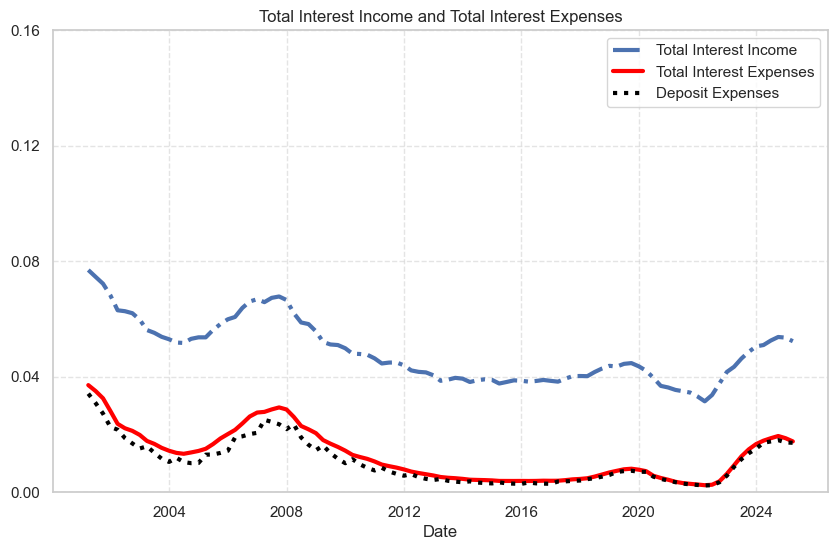

In [16]:
# use seaborn to plot 'Total Interest Income' and 'Total Interest Expenses':
fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(x='Date', y='Interest Income Rate', data=main, ax=ax, errorbar=None, ls='-.', lw=3)
sns.lineplot(x='Date', y='Interest Expenses Rate', data=main, ax=ax, errorbar=None, color='red', lw=3)
sns.lineplot(x='Date', y='Deposit Expenses Rate', data=main, ax=ax, errorbar=None, lw=3, ls=':', color='black')
plt.legend(labels=['Total Interest Income', 'Total Interest Expenses', 'Deposit Expenses'])
plt.title('Total Interest Income and Total Interest Expenses')
plt.xlabel('Date')
plt.ylabel(None)
# put y-ticks every 0.04 units:
ax.yaxis.set_major_locator(MultipleLocator(0.04))
plt.ylim(0, 0.16)
plt.grid(True, linestyle='--', alpha=0.6, color='lightgray')
plt.show()

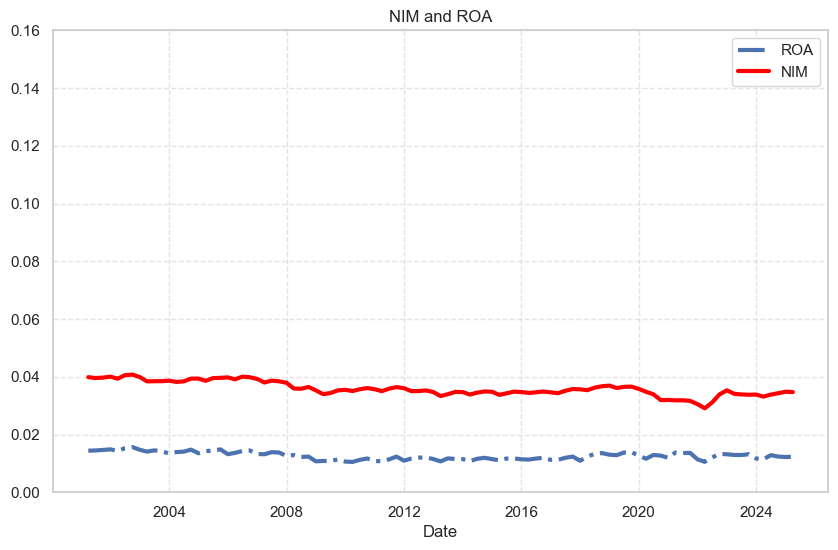

In [18]:
# put two plots side by side, the one above and NIM with ROA:
fig, ax = plt.subplots(figsize=(10, 6))

sns.lineplot(x='Date', y='Return on Assets', data=main, ax=ax, errorbar=None, ls='-.', lw=3)
sns.lineplot(x='Date', y='NIM', data=main, ax=ax, errorbar=None, ls='-', lw=3, color='red')
plt.legend(labels=['ROA', 'NIM'])
plt.title('NIM and ROA')
plt.xlabel('Date')
plt.ylabel(None)
plt.ylim(0, 0.16)
plt.grid(True, linestyle='--', alpha=0.6, color='lightgray')
plt.show()

## Begenau et. al (2025)

In [23]:
df = main[['Date', 'IDRSSD', 'Financial Institution Name', 
           'Total Assets', 'HTM Securities', 'AFS Securities', 'FFS', 'Equity Securities', 'Cash',
           'Transaction Deposits', 'Time Deposits', 'Time Deposit Expenses', 'Transaction Deposit Expenses', 
           'Cash, Securities and FFS per Asset', 'Cash per Asset', 'Securities per Assets', 'Securities and FFS per Asset',
           'Total Securities']]

In [24]:
# Keep 2010Q1 to 2022Q4:
df = df[(df['Date'] >= '2010-01-01') & (df['Date'] <= '2022-12-31')]

In [25]:
df['Log Total Assets'] = np.log(df['Total Assets'])

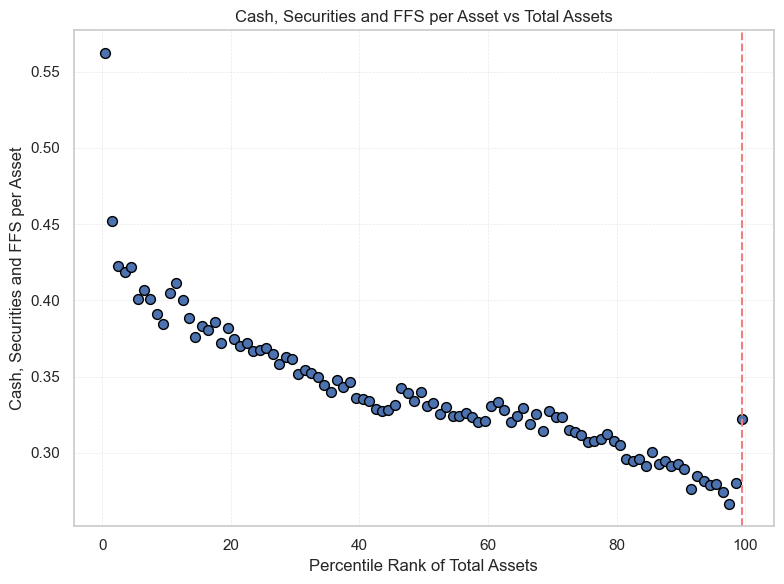

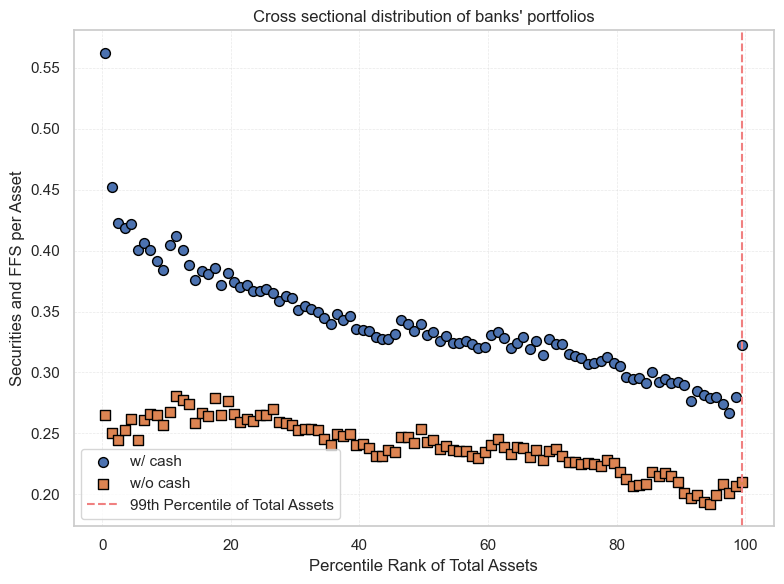

In [26]:
# make a scatter plot of 'Cash, Securities and FFS per Asset' vs 'Total Assets' using seaborn:
plt.figure(figsize=(8, 6))
binned_scatter(df['Total Assets'], df['Cash, Securities and FFS per Asset'], q=100, marker='o', dispersion=False)
plt.axvline(x=.995, color='lightcoral', linestyle='--', label='99th Percentile of Total Assets')
plt.title('Cash, Securities and FFS per Asset vs Total Assets')
plt.tight_layout()
plt.show()

# make a scatter plot of 'Securities and FFS per Asset' vs 'Total Assets' using seaborn:
plt.figure(figsize=(8, 6))
binned_scatter(df['Total Assets'], df['Cash, Securities and FFS per Asset'], q=100, marker='o', dispersion=False, label='w/ cash')
binned_scatter(df['Total Assets'], df['Securities and FFS per Asset'], q=100, marker='s', dispersion=False, label='w/o cash')
plt.legend()
plt.axvline(x=.995, color='lightcoral', linestyle='--', label='99th Percentile of Total Assets')
plt.title("Cross sectional distribution of banks' portfolios")
plt.legend(['w/ cash', 'w/o cash', '99th Percentile of Total Assets'])
plt.tight_layout()